## Strikeouts Exercise

Hello! This notebook walks through the exercise of predicting a pitcher's strikeout percentage during the second half of the season, using data available at the All-Star break. 

The strategy here is to use the available data to create one or more predictive models, then use these to make a forecast of second-half K%.

The predictive models will relate first-half K% to other first-half data points. The models will be fit using most of the available data. The models will then be evaluated using the remainder of the data, to test out-of-sample properties. Finally the models will be used to make an extrapolation about second-half K%



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import neighbors

### Data

First, let's read and format the data.

Second, let's separate the data into a training set and a testing set. The training set will be used to fit our candidate models, and the test set will be used to check their out-of-sample properties.

In [2]:
df = pd.read_csv('strikeouts.csv')  # use URL?

# fix IP
df['IP'] = np.floor(df['IP']) + 10/3 * (df['IP'] - np.floor(df['IP']))

# set index
df.set_index("fangraphs_id", inplace=True)


# split up data ... set aside ~ 10% of the data at random
np.random.seed(1980)
test_idx = np.random.uniform(size=len(df.index)) <= 0.10
test = df.iloc[test_idx,:]
train = df.iloc[[not t for t in test_idx], :]


### Exploratory analysis

Now let's take an overview look of the data.

Below are charts showing scatter plots with first-half K% along the y-axis and one of the other variables along the x-axis.

Note that FB% is omitted becuase FB% = 1-GB%-LD%.

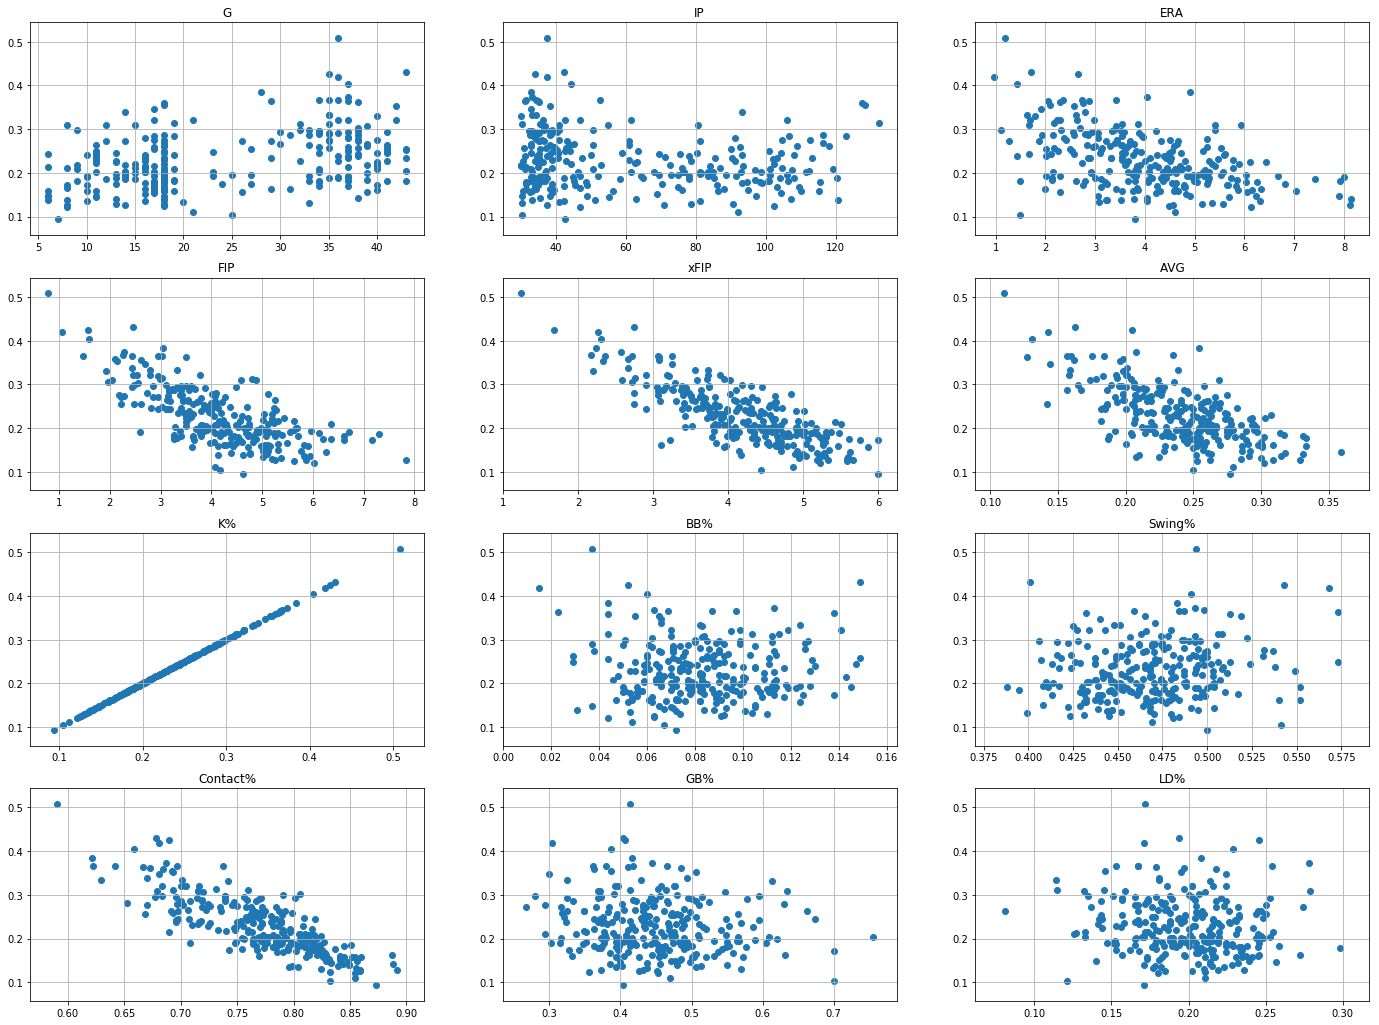

In [3]:
fig, ax = plt.subplots(4,3, figsize = (24, 18))

for i, x in enumerate(ax.ravel()):
    x.scatter(train.iloc[:,i+2], train["K%"])
    x.set_title(train.iloc[:,i+2].name)
    x.grid(True)
    
plt.show()

A few observations at this point. The K% chart shows that there is a possible outlier having a K% > 0.5 (Craig Kimbrel). Besides that, the pitchers are densely packed between 0.1 and about 0.3, and somewhat more sparsely distributed from 0.3 to about 0.425. That is to say, the K% distribution has a rightward skew.

The ERA, FIP, xFIP, AVG, and Contact% charts all show a strong negative relationship with K%. 

The games played chart shows bimodality. 

The other charts are more difficult to characterize.

### Modeling

#### Linear Regression

Using the insights from the charts, we can take a pass at modeling first-half K% in terms of the available data.

Let's start with a linear regression. As mentioned above, five of the variables appear to have strong linear relationships with K%. Three of them -- ERA, FIP and xFIP -- are somewhat related, so let's just take one of these. At a glance, xFIP seems to be the most explanatory of K%, so let's use that. We'll also include AVG and Contact%.


                            OLS Regression Results                            
Dep. Variable:                     K%   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     449.9
Date:                Tue, 30 Oct 2018   Prob (F-statistic):          3.22e-103
Time:                        20:53:32   Log-Likelihood:                 588.08
No. Observations:                 267   AIC:                            -1168.
Df Residuals:                     263   BIC:                            -1154.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8606      0.025     34.626      0.0

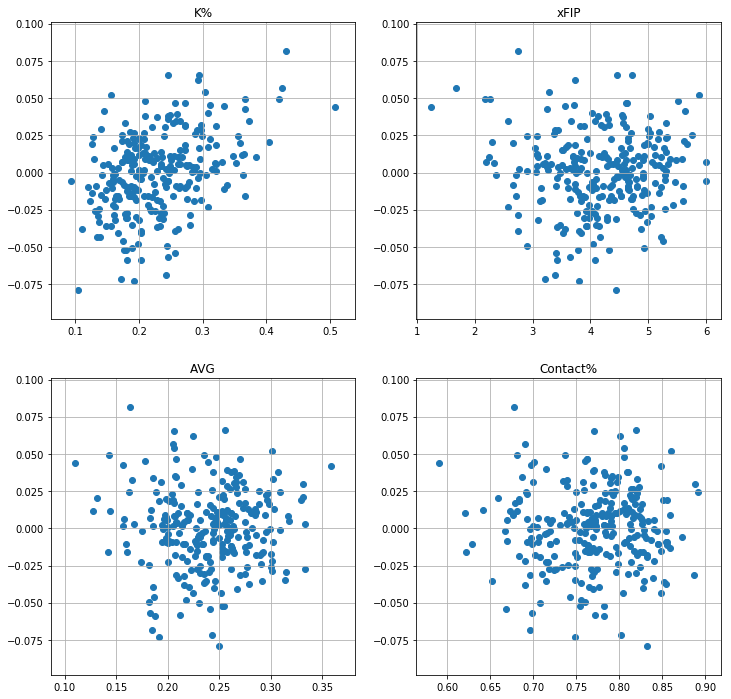

In [4]:
X = train.iloc[:,[6,7,11]]
y = train["K%"]

ols = sm.OLS(y, sm.add_constant(X))
ols_fit = ols.fit()
print(ols_fit.summary())


fig, ax = plt.subplots(2,2, figsize = (12, 12))

names = ["K%", "xFIP", "AVG", "Contact%"]

for i, x in enumerate(ax.ravel()):
    x.scatter(train[names[i]], ols_fit.resid)
    x.set_title(names[i])
    x.grid(True)
    
    
plt.show()

Regression outputs and residual charts are shown above.

The simple regression model does quite well. The regressors are strongly significant, the coefficient signs are as expected, and the model accounts for nearly all of the variation in K%. Some further testing verifies that at the margin, including additional regressors does not deliver appreciable improvements in R-squared or information criteria.

A potential concern with this output is that the estimated residuals seem to have a positive correlation with K%.

Now that we've got a model in hand, let's try it against the test data.

In [5]:
Xtest = test.iloc[:,[6,7,11]]
ols_fit.predict(sm.add_constant(Xtest))
rmse_ols = np.sqrt(np.sum((ols_fit.predict(sm.add_constant(Xtest)) - test["K%"])**2) / len(test["K%"]))
print('RMSE: '+str(rmse_ols))

RMSE: 0.0234958315357


#### k Nearest Neighbors

As an alternative to the linear regression, let's try predicting K% using the k nearest neighbors approach using k=5 neighbors.

As with the linear model, let's consider xFIP-AVG-Contact% space.

In [6]:
knn = neighbors.KNeighborsRegressor(5)
knn_fit = knn.fit(X,y)
rmse_knn = np.sqrt(np.sum((knn_fit.predict(Xtest) - test["K%"])**2) / len(test["K%"]))
print('RMSE: '+str(rmse_knn))

RMSE: 0.0283819758249


#### Model average

Looks like the performance of the nearest neighbors prediction, measured in RMSE terms, is similar if a little worse than the OLS. So, let's adopt as our model an average of the two.

In [7]:
def avg_predict(X, ols, knn, ols_rmse, knn_rmse):
    """ delivers averaged prediction """
    
    w_ols = 1 - (ols_rmse / (ols_rmse + knn_rmse))
    w_knn = 1 - w_ols
    
    predict = w_ols * ols.predict(sm.add_constant(X)) + w_knn * knn.predict(X)
    
    return predict
    
    

### Evaluation

Now that we've settled on a prediction model, let's see how it does against the second-half K%.

In [9]:
predict = avg_predict(df.iloc[:,[6,7,11]], ols_fit, knn_fit, rmse_ols, rmse_knn)
rmse_2nd = np.sqrt(np.sum((predict - df["2ndHalfK%"])**2) / len(df["2ndHalfK%"]))
print('RMSE: '+str(rmse_2nd))
df['predict'] = predict
df.iloc[:,[0,15,17]]

RMSE: 0.0540243651812


,Name,2ndHalfK%,predict
fangraphs_id,,,
2036,Clayton Kershaw,0.249,0.314188
3137,Max Scherzer,0.324,0.331041
10603,Chris Sale,0.366,0.340950
6345,Chris Archer,0.303,0.275004
1994,Ivan Nova,0.212,0.181898
3200,Ervin Santana,0.201,0.190651
2717,Rick Porcello,0.200,0.190516
13074,Yu Darvish,0.297,0.253135
3254,Jeff Samardzija,0.216,0.264916


### Conclusion

To recap, we fit two models to explain K% in terms of other pitching variables, tested the models to determine their out-of-sample performance, then predicted second-half K% using an average of the two models.

The RMSE of the averaged models relative to second-half K% indicates that our averaged model performed okay but not spectacularly. Looking back to the distribution of first-half K%, a distance of 0.5 is non-negligible.

Further avenues for improving the predictions could include changing the feature selection choice (ie not sticking with just xFIP, AVG and Contact%) or including other predictive methods in the model suite.

Thanks for reading!